# Imports

In [50]:
import os
import re
import nltk
import gzip
import shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support
from gensim.models.keyedvectors import KeyedVectors
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers  import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import layers
from keras import preprocessing

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Download and extract the data

In [3]:
if('blogs.zip' not in os.listdir()):
    !curl 'http://u.cs.biu.ac.il/~koppel/blogs/blogs.zip' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' -H 'User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' -H 'Referer: http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm' -H 'Accept-Encoding: gzip, deflate' -H 'Accept-Language: en-US,en;q=0.9' --compressed --output blogs.zip
    with zipfile.ZipFile('blogs.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

# Data cleaning and exploration

In [4]:
bloggers = os.listdir('blogs/')
print("There are {} bloggers".format(len(bloggers)))

There are 19320 bloggers


In [5]:
path = 'blogs/'

stop_words = nltk.corpus.stopwords.words("english")

f = open(path+bloggers[0],'r',encoding="utf-8")

xml = f.read()

tags = set()
l = re.findall('<[^/].*?>',xml)
for el in l:
    tags.add(el)
print("The set of tags in the xml files are: {}".format(tags))

The set of tags in the xml files are: {'<date>', '<Blog>', '<post>'}


In [6]:
def data_2_frame(bloggers, sw = True):
    
    idx = []
    gender = []
    age = []
    industry = []
    astrologic = []
    dates = []
    posts = []
        
    for blogger in bloggers:

        try:

            f = open(path+blogger,'r',encoding="utf-8")
            xml = f.read()

        except UnicodeDecodeError:

            f = open(path+blogger,'r',encoding="latin-1")
            xml = f.read()
        
        if(sw):
            xml = re.sub(r'\b(' + r'|'.join(stop_words) + r')\b\s*','', xml)
            
        temp = re.findall('<post.*?>(.*?)</post>',xml,flags=re.DOTALL)
        
        posts += temp
        
        dates += re.findall('<date.*?>(.*?)</date>',xml,flags=re.DOTALL)

        nb_posts = len(temp)

        tmp = blogger.split(".")

        idx        += [tmp[0]]*nb_posts
        gender     += [tmp[1]]*nb_posts
        age        += [tmp[2]]*nb_posts
        industry   += [tmp[3]]*nb_posts
        astrologic += [tmp[4]]*nb_posts
    
    
    dico = {'id':idx,
        'gender':gender,
        'age':age,
        'industry':industry,
        'astrologic':astrologic,
        'post':posts,
        'date':dates}

    return pd.DataFrame.from_dict(dico)

In [7]:
data = data_2_frame(bloggers,True)

In [8]:
data.describe()

,id,gender,age,industry,astrologic,post,date
count,681288,681288,681288,681288,681288,681288,681288
unique,19320,2,26,40,12,612001,2616
top,449628,male,17,indUnk,Cancer,\n\n\t \n urlLink \n,"02,August,2004"
freq,4221,345197,80859,251015,65048,399,16545


In [9]:
data.head()

,id,gender,age,industry,astrologic,post,date
0,4200843,male,39,Technology,Sagittarius,"\n\n \n Why suns , obsession trying l...","21,August,2004"
1,4200843,male,39,Technology,Sagittarius,\n\n \n I'ordered Counter Strike:CZ ...,"18,August,2004"
2,4200843,male,39,Technology,Sagittarius,\n\n \n Remember jokes? Well I I nev...,"18,August,2004"
3,4200843,male,39,Technology,Sagittarius,\n\n \n If 'watch 'Waking Dead' make...,"16,August,2004"
4,4200843,male,39,Technology,Sagittarius,\n\n \n Sunday always feels like Sun...,"15,August,2004"


In [43]:
print("There are {0:.2f}% posts per male, and {1:.2f}% for female".format(data.\
gender[data.gender == 'male'].count()*100/data.gender.count(),data.gender[data.gender == 'female']\
.count()*100/data.gender.count()))

There are 50.67% posts per male, and 49.33% for female


In [11]:
words = []
posts = data.post.values
word_per_post = []

for post in posts:
    
    words+=post.split(" ")
    
    word_per_post.append(len(post.split(" ")) - np.sum(np.array(post.split(" ")) == ""))
    
unique_words = pd.unique(words)

print("There are {} words and {} unique words, that are non stop words in the corpus.".format(len(words),len(unique_words)))
print("Maximum words number per post: {}\nMinimum words number per post: {}\nAverage words number per post: {}\nMedian: {}\n80% of posts contains less or equal than {} words"\
      .format(np.max(word_per_post),np.min(word_per_post),np.mean(word_per_post),np.median(word_per_post),np.sort(word_per_post)[np.int(len(word_per_post)*0.8)]))

There are 101264977 words and 3912652 unique words, that are non stop words in the corpus.
Maximum words number per post: 78477
Minimum words number per post: 2
Average words number per post: 121.63884730099458
Median: 71.0
80% of posts contains less or equal than 180 words


# Baseline

In [16]:
maxlen = 180
max_words = 50000
embedding_dim = 300

tokenizer = Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(data.post.values)

sequences = np.array(tokenizer.texts_to_sequences(data.post.values))

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

X = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

y = data.gender.values

sss = StratifiedShuffleSplit(test_size = 0.25)

# utilise plabels au lieu de labels si tu veux tester sur les periodes
for train_index, test_index in sss.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

Found 1218159 unique tokens.


((510966, 180), (170322, 180), (510966, 2), (170322, 2))

In [51]:
def get_model(maxlen,max_words,embedding_dim,dropout = False):

    model = Sequential()
    model.add(Embedding(max_words,embedding_dim, input_length = maxlen))
    model.add(Flatten())
    model.add(Dense(5,activation="sigmoid"))
    if(dropout):
        model.add(Dropout(0.5))
        
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

def plot_acc(history):
    
    sns.set()

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(20,10))

    epochs = range(1, len(acc) + 1)

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_4 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 270005    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 15,270,011
Trainable params: 15,270,011
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
model = get_model(maxlen, max_words, embedding_dim,dropout=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 5, batch_size = 256, validation_split = 0.2)

Train on 408772 samples, validate on 102194 samples
Epoch 1/5
408772/408772 [==============================] - 38s 94us/step - loss: 0.6333 - acc: 0.6293 - val_loss: 0.5883 - val_acc: 0.6925
Epoch 2/5
408772/408772 [==============================] - 37s 91us/step - loss: 0.5692 - acc: 0.6960 - val_loss: 0.5764 - val_acc: 0.6916
Epoch 3/5
408772/408772 [==============================] - 37s 91us/step - loss: 0.4759 - acc: 0.7613 - val_loss: 0.6212 - val_acc: 0.6753
Epoch 4/5
408772/408772 [==============================] - 37s 90us/step - loss: 0.3887 - acc: 0.8134 - val_loss: 0.7127 - val_acc: 0.6615
Epoch 5/5
408772/408772 [==============================] - 37s 91us/step - loss: 0.3346 - acc: 0.8416 - val_loss: 0.7821 - val_acc: 0.6494


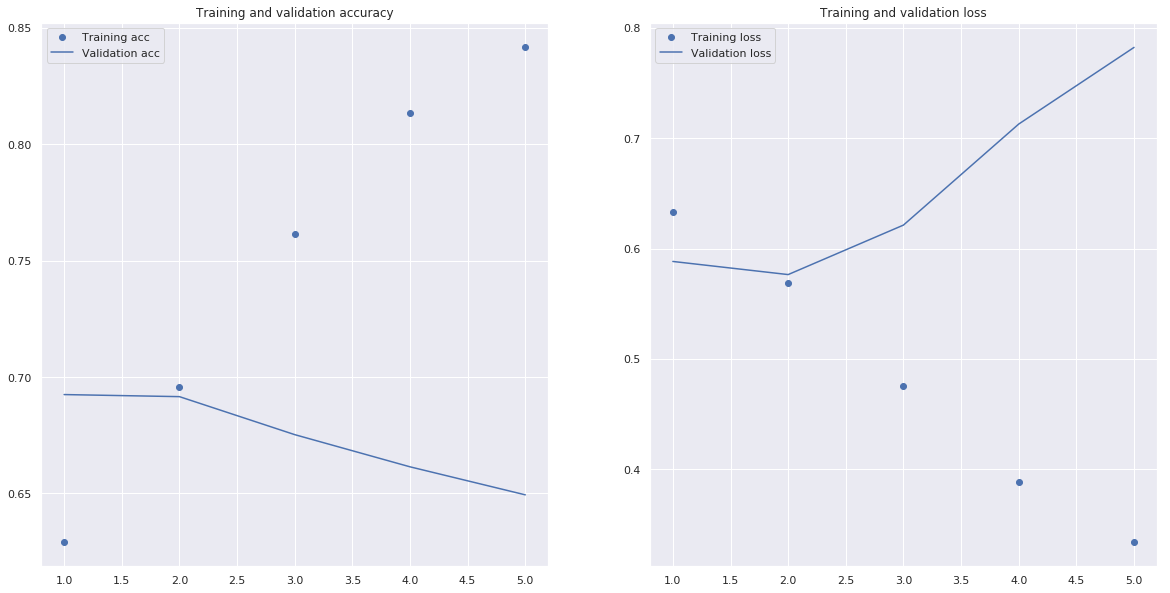

In [53]:
plot_acc(history)

In [54]:
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

170322/170322 [==============================] - 17s 99us/step
evaluate on test set  [0.7820995309783288, 0.6498162304355187]


In [55]:
results = model.evaluate(X_train, y_train['male'].values)
print("evaluate on train set ",results)

510966/510966 [==============================] - 45s 88us/step
evaluate on train set  [0.30443763820281683, 0.8706332710971062]


In [56]:
y_pred = model.predict(X_test)

pr, rc, fs,_ = precision_recall_fscore_support(y_test['male'].values,y_pred[:,0].round(),average='micro')

In [57]:
print("precision is {}%, recall is {}% and f1 score is {}%".format(pr*100, rc*100, fs*100))

precision is 64.9816230434119%, recall is 64.9816230434119% and f1 score is 64.9816230434119%


In [58]:
model = get_model(maxlen, max_words, embedding_dim,dropout=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 2, batch_size = 256)

results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_5 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 270005    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 15,270,011
Trainable params: 15,270,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
510966/510966 [==============================] - 49s 95us/step - loss: 0.6298 - acc: 0.6347
Epoch 2/2
170322/170322

# Use of a pretrained embeddings

In [59]:
if('GoogleNews-vectors-negative300.bin.gz' not in os.listdir()):
    !curl 'https://doc-0s-bo-docs.googleusercontent.com/docs/securesc/irhn5id42n45amehdukhdmveaa64qdca/p3cdn432vvf0g873qt5fohervngkocsn/1547913600000/06848720943842814915/12338030662361016533/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&nonce=te8dhbikk60gq&user=12338030662361016533&hash=jmfhhq8ou6vcslfnjc1a36e5sjsap20h' -H 'authority: doc-0s-bo-docs.googleusercontent.com' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' -H 'x-client-data: CIa2yQEIprbJAQipncoBCKijygEIv6fKAQiQqMoBCOKoygEY+aXKAQ==' -H 'referer: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'cookie: AUTH_7ncsoht60h5nj3290k7ksjvs3qm9agnm_nonce=te8dhbikk60gq; NID=146=2m64YwK1FU_-wWYEr0N6qIT8KCPul94SVvGNE1YFUODGL-9ZZYgtf0PjHL_TrgeguaQjrWszdcM8aTlORHFViPx5R3pkEaM2uaQDIPyQkNY-ns5aQ0_77DSWxzvulfHWNxRIonT9b28IBORFdd1Cb8nPngy3F8nCQarRxGO2hNM' --compressed --output GoogleNews-vectors-negative300.bin.gz
    with gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb') as f_in:
        with open('GoogleNews-vectors-negative300.bin', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

In [60]:
embeddings_index = {}

with open("GoogleNews-vectors-negative300.txt") as f:
    for i,line in enumerate(f):
        if(i!=0):
            values = line.split()
            word = values[0]
            embeddings_index[word] = np.array(values[1:], dtype='float32')
        
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 2999999 word vectors.


In [61]:
embedding_dim = 300

c = 0
embedding_matrix = np.zeros((max_words, embedding_dim))

# eliminer les mots vides de l'embedding car il n'existe pas dans nos donnees
for word, i in word_index.items():
    if word not in stop_words and c < max_words:
    
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[c] = embedding_vector
            c+=1
            
c

50000

In [62]:
model = get_model(maxlen, max_words, embedding_dim, dropout=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_6 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 270005    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 15,270,011
Trainable params: 15,270,011
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [64]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 5, batch_size = 256, validation_split = 0.2)

Train on 408772 samples, validate on 102194 samples
Epoch 1/5
408772/408772 [==============================] - 20s 49us/step - loss: 0.6905 - acc: 0.5306 - val_loss: 0.6861 - val_acc: 0.5510
Epoch 2/5
408772/408772 [==============================] - 18s 43us/step - loss: 0.6807 - acc: 0.5513 - val_loss: 0.6820 - val_acc: 0.5611
Epoch 3/5
408772/408772 [==============================] - 17s 42us/step - loss: 0.6713 - acc: 0.5642 - val_loss: 0.6821 - val_acc: 0.5632
Epoch 4/5
408772/408772 [==============================] - 18s 44us/step - loss: 0.6632 - acc: 0.5733 - val_loss: 0.6870 - val_acc: 0.5534
Epoch 5/5
408772/408772 [==============================] - 17s 43us/step - loss: 0.6556 - acc: 0.5805 - val_loss: 0.6851 - val_acc: 0.5547


In [65]:
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

170322/170322 [==============================] - 14s 85us/step
evaluate on test set  [0.6842073553975629, 0.5557532203694272]


In [66]:
results = model.evaluate(X_train, y_train['male'].values)
print("evaluate on train set ",results)

510966/510966 [==============================] - 45s 89us/step
evaluate on train set  [0.6431674028108962, 0.6055353976594858]


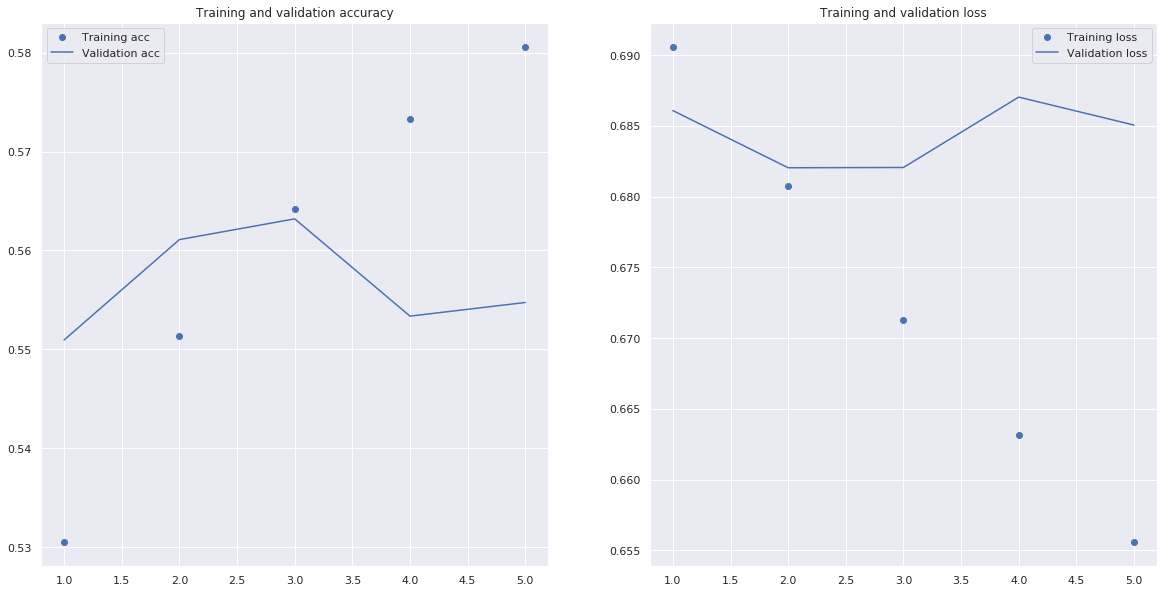

In [67]:
plot_acc(history)

In [68]:
model = get_model(maxlen, max_words, embedding_dim, dropout=True)
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 3, batch_size = 256)
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_7 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 270005    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 6         
Total params: 15,270,011
Trainable params: 15,270,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
510966/510966 [==============================] - 36s 70us/step - loss: 0.6904 - acc: 0.5302
Epoch 2/3
510966/510966

## with non-static embeddings

In [70]:
model = get_model(maxlen, max_words, embedding_dim, dropout = True)
model.layers[0].set_weights([embedding_matrix])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_9 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 270005    
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 15,270,011
Trainable params: 15,270,011
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 5, batch_size = 256, validation_split = 0.2)

Train on 408772 samples, validate on 102194 samples
Epoch 1/5
408772/408772 [==============================] - 41s 101us/step - loss: 0.6501 - acc: 0.6148 - val_loss: 0.6020 - val_acc: 0.6717
Epoch 2/5
408772/408772 [==============================] - 50s 122us/step - loss: 0.5887 - acc: 0.6907 - val_loss: 0.5902 - val_acc: 0.6773
Epoch 3/5
408772/408772 [==============================] - 42s 102us/step - loss: 0.5301 - acc: 0.7388 - val_loss: 0.6102 - val_acc: 0.6684
Epoch 4/5
408772/408772 [==============================] - 48s 117us/step - loss: 0.4638 - acc: 0.7848 - val_loss: 0.6670 - val_acc: 0.6625
Epoch 5/5
408772/408772 [==============================] - 38s 92us/step - loss: 0.4033 - acc: 0.8224 - val_loss: 0.7311 - val_acc: 0.6483


In [72]:
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

170322/170322 [==============================] - 15s 88us/step
evaluate on test set  [0.7263638163711487, 0.6498632002926129]


In [73]:
results = model.evaluate(X_train, y_train['male'].values)
print("evaluate on train set ",results)

510966/510966 [==============================] - 46s 89us/step
evaluate on train set  [0.3699500188116859, 0.8395353115469146]


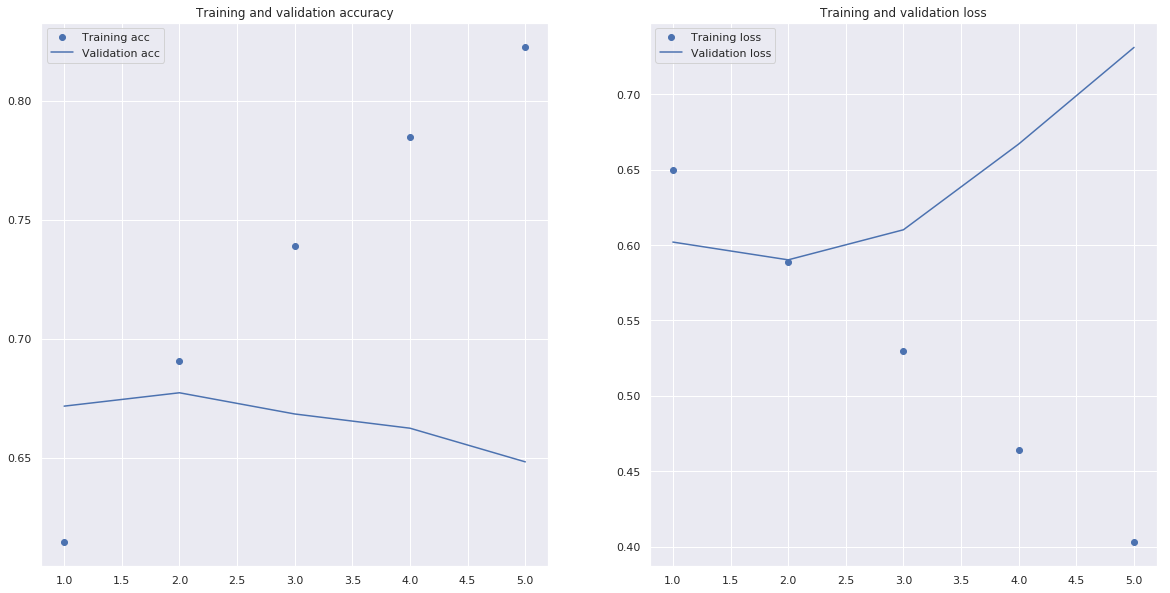

In [74]:
plot_acc(history)

In [75]:
model = get_model(maxlen, max_words, embedding_dim, dropout=True)
model.layers[0].set_weights([embedding_matrix])
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 2, batch_size = 256)
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 180, 300)          15000000  
_________________________________________________________________
flatten_10 (Flatten)         (None, 54000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 270005    
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 15,270,011
Trainable params: 15,270,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
510966/510966 [==============================] - 57s 113us/step - loss: 0.6429 - acc: 0.62081s - lo
Epoch 2/2
17032